<a href="https://colab.research.google.com/github/AngusTheMack/make-machine-learning/blob/master/Make_Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make Day 
I had the pleasure of going to a [Make Day](https://make.offerzen.com/) hosted by [Offerzen](https://www.offerzen.com/) - where we learnt to make Machine Learning models with Tensorflow, and how to use [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true) in order to easily create them.

There were multiple tasks we could accomplish, and one of them was to build models of the different datasets out there. I completed this by creating models for the MNIST dataset, the MNIST-Fashion dataset and the CIFAR dataset.

I thought this Notebook might be a useful reference for anyone else who wants to sink their teeth into some examples. I hope to explain everything as best as I can, however, if you feel that my explanations or models can be better - please feel free to contact me on [my email](mailto:mckang009@myuct.ac.za)


I achieved a reasonable accuracy for the first two, with the last one not being entirely great:

 DataSet | Accuracy 
  --- | --- 
MINST | 98%
MNIST Fashion | 89%
CIFAR | 10%

I also had the opportunity to go to an amazing talk by [Aerobotics](https://www.aerobotics.io/) on using Convolutional Neural Networks (CNN) for image classification, and whilst I do not use a CNN for the first dataset, they are very important for the second and third datasets. The talk was extremely illuminating and I am going to include some of what they went through in this Notebook as it definitely does a great job at explaining some of the core concepts, and goes into a lot of depth. 

Adding to this, their CNN overview showed me how I could increase my accuracy for the CIFAR dataset from **10 to 90%**.

## What is a Neural Network?

Here is the definition of a Neural Network from [their Notebook](https://colab.research.google.com/drive/1BF9gBZhqoNELlnofxSFymYMMT_T0Okmv) that creates a CNN for the CIFAR dataset:

> In brief, a neural network is an approximation to a function $\hat f(x; \theta) \approx f(x)$ that is parameterised by the coefficients $\theta$. The parameters, $\theta$, are optimised through a process called $\textit{backpropagation}$, in which the $\textit{error}$ in the approximation, $\hat f(x; \theta)$, is used to update the parameters, $\theta$. The error is obtained by first defining a $\textit{loss function}$, which specifies how to penalise the deviation of the neural network's outputs from the desired outputs. To create and train a neural network, you must first define:

> 1. The "function" , or neural network architecture
2. The loss function
3. The training algorithm - in general this is simply computing the model outputs, calculating the loss, and updating the model parameters according to the gradient with respect to the parameters.

Onwards!

In the following cell, we set up our development environment for this Notebook, this entails:
* Tensorflow (for the Machine Learning)
* Numpy for working with big arrays, and maths
* Matplotlib for more math

Before continuing I thought it best to better outline more about TensorFlow. However, if you already know what that is - simply skip it.

### TensorFlow
[TensorFlow's website](https://www.tensorflow.org/) describes it as the following:</p>
*An open source software library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices. Originally developed by researchers and engineers from the Google Brain team within Google’s AI organization, it comes with strong support for machine learning and deep learning and the flexible numerical computation core is used across many other scientific domains.*</p>

It acts as a neat way to make neural networks, and visualize the results in a really straightforward manner.

In [11]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

Populating the interactive namespace from numpy and matplotlib


**Running in eager mode**
* Eager mode makes TensorFlow more imperative, it evaluates operations as it reads them
* The following snippet simply ensures that TensorFlow is in eager mode.

The [docs]((https://www.tensorflow.org/guide/eager) describe it as:</p>
"Eager execution changes how TensorFlow operations behave—now they immediately evaluate and return their values to Python. tf.Tensor objects reference concrete values instead of symbolic handles to nodes in a computational graph. Since there isn't a computational graph to build and run later in a session, it's easy to inspect results using print() or a debugger. Evaluating, printing, and checking tensor values does not break the flow for computing gradients.""
</p>


In [12]:
try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running Eagerly')

Running in Eager mode.


Starting the initial MNIST dataset for number classification

The code below downloads the dataset, and creates the training set to use, as well as the testing set. We divide the images by 255 in order to normalise the data so that it will output something between 0 and 1 - and not a number between 0 and 255.

(Fun fact - the data was collected by the [National Institute of Standards and Technology](https://en.wikipedia.org/wiki/MNIST_database))

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

**Print Sample**
* I always find it useful to better understand the sample space with a visual example, and printing out 25 random images with their associated labels always gives me a good idea of the dataset.

25 random images


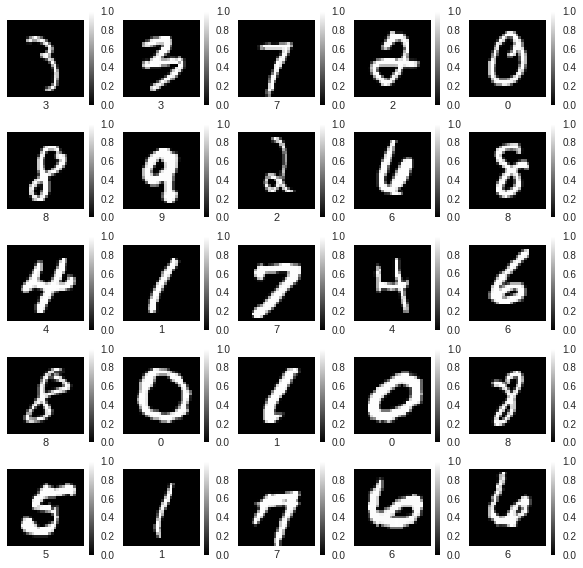

In [14]:
print("25 random images")
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  random_index = np.random.randint(0, len(x_train))
  plt.imshow(x_train[random_index], cmap='gray')
  plt.colorbar()
  numerical_label = y_train[random_index]
  plt.xlabel(numerical_label)

Setup the arrays that will be passed into our model</p>
`tf.convert_to_tensor` converts the given value to a Tensor.

"This function converts Python objects of various types to Tensor objects. It accepts Tensor objects, numpy arrays, Python lists, and Python scalars."  - [docs](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor)

"A tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes." - [docs](https://www.tensorflow.org/guide/tensors)

In [0]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int64)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int64)

## MNIST Model
We create a `Sequential` model, which is a linear stack of layers. As you can see below, we add more layers by simply defining them within our model.

We initially `Flatten` our model, this is in order to ensure that the *input shape* is correct  for our network. Once we have flattened it, we can feed that into a densely-connected NN layer where the `output = activation(dot(input, kernel) +  bias)`.

In our model, the `relu` activation is used. `relu` stands for *Rectified Linear Unit* .

That gets fed into a dropout layer - which is a technique for reducing overfitting, by simply dropping units in a hidden network.

Finally, we add another densely-connected layer with the `softmax` activation function.

In [0]:
mnist_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

## Compiling the Model
This is done in order to configure the learning method. The `compile` method takes three arguments
1. An optimizer - which shape and mold your model into its most accurate form by changing the weights.
2. A loss function - the objective that the model will try to minimize.
3. A list of metrics - what metrics to track.

We use the following:
* Adam Optimizer
* sparse_categorical_crossentropy
* accuracy

In [0]:
mnist_model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

Running the model


In [18]:

mnist_model.fit(x_train, y_train, epochs=5)
mnist_model.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2231 - acc: 0.9334
Epoch 2/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0996 - acc: 0.9700
Epoch 3/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0696 - acc: 0.9783
Epoch 4/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0547 - acc: 0.9822
Epoch 5/5
313/313 [==============================] - 1s 4ms/step


[0.0660641501596081, 0.9795]

Testing the Model

In [0]:
predicted = mnist_model.predict_classes(x_test)

Outputting Confusion matrix


Checking 25 Random predictions


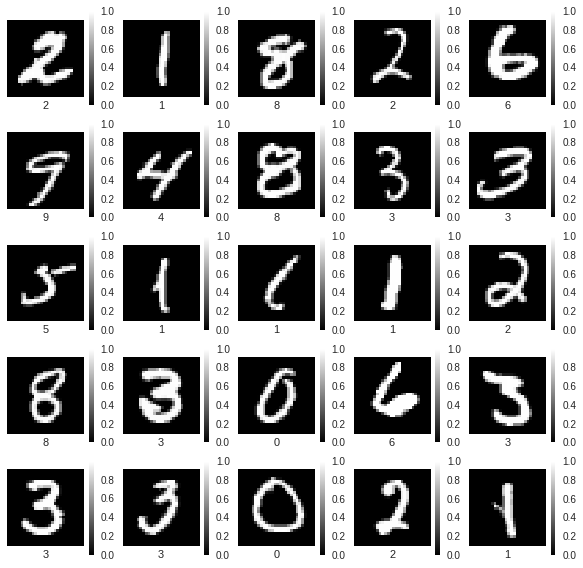

In [20]:
print("Checking 25 Random predictions")
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  random_index = np.random.randint(0, len(list(x_test)))
  plt.imshow(tf.gather(x_test, random_index), cmap='gray')
  plt.colorbar()
  numerical_label = predicted[random_index]
  plt.xlabel(numerical_label)

# MNIST Fashion
A dataset of 60000 28x28 black and white training images, with 10 diufferent labels. I do not go into the same amount of detail as with the first dataset with regard to the code.

In [21]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = fashion_mnist.load_data()

text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Construct a validation set from the last 10000 images and labels from =
validation_images = train_and_validation_images[-10000:, :, :]
validation_labels = train_and_validation_labels[-10000:]

# Construct a training set from the first 50000 images and labels.
train_images = train_and_validation_images[:50000, :, :]
train_labels = train_and_validation_labels[:50000]

4423680/4422102 [==============================] - 0s 0us/step


Verifying input is in the correct form

Finished downloading MNIST images
50000 images to train with
Displaying 25 random images to get an idea of the dataset


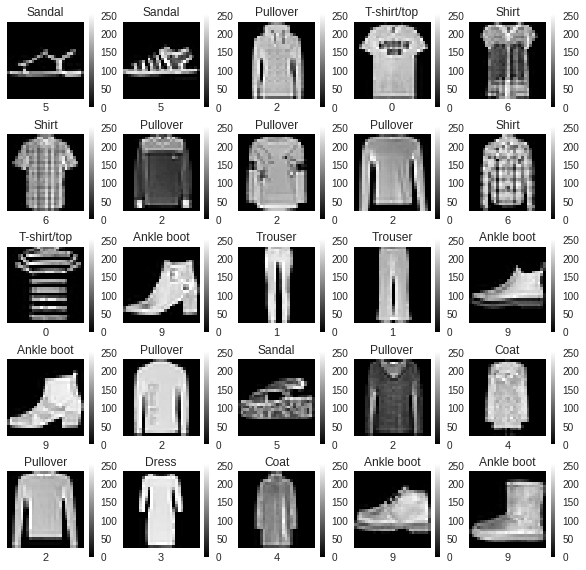

In [22]:
print("Finished downloading MNIST images")
print(len(train_images), "images to train with")
print("Displaying 25 random images to get an idea of the dataset")
randomFashionImages = []
  
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  random_index = np.random.randint(0, len(train_images))
  randomFashionImages.append(random_index)
  plt.imshow(train_images[random_index], cmap='gray')
  plt.colorbar()
  numerical_label = train_labels[random_index]
  text_description = text_labels[numerical_label]
  plt.xlabel(numerical_label)
  plt.title(text_description)

Set up the model to run, and printing out a summary of it

In [23]:
fashionModel = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
fashionModel.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
fashionModel.add(tf.keras.layers.MaxPooling2D(pool_size=2))
fashionModel.add(tf.keras.layers.Dropout(0.3))
fashionModel.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
fashionModel.add(tf.keras.layers.MaxPooling2D(pool_size=2))
fashionModel.add(tf.keras.layers.Dropout(0.3))
fashionModel.add(tf.keras.layers.Flatten())
fashionModel.add(tf.keras.layers.Dense(256, activation='relu'))
fashionModel.add(tf.keras.layers.Dropout(0.5))
fashionModel.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
fashionModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
__________

Compile the model

In [0]:
fashionModel.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

Make the arrays TF friendly

In [0]:
train_images = train_images[:, :, :, np.newaxis]
validation_images  = validation_images[:, :, :, np.newaxis]

x_train = tf.convert_to_tensor(train_images,dtype=tf.float32)
y_train = tf.convert_to_tensor(train_labels, dtype=tf.int64)

x_test  = tf.convert_to_tensor(validation_images, dtype=tf.float32)
y_test  = tf.convert_to_tensor(validation_labels, dtype=tf.int64)

In [26]:
print(x_train.shape)

(50000, 28, 28, 1)


Train the model

In [27]:
fashionModel.fit(x_train, y_train, epochs=20)


Epoch 1/10
1563/1563 [==============================] - 128s 82ms/step - loss: 8.3427 - acc: 0.4764
Epoch 2/10
1563/1563 [==============================] - 121s 77ms/step - loss: 5.1739 - acc: 0.6709
Epoch 3/10
1563/1563 [==============================] - 117s 75ms/step - loss: 4.9981 - acc: 0.6838
Epoch 4/10
1563/1563 [==============================] - 119s 76ms/step - loss: 4.8241 - acc: 0.6968
Epoch 5/10
1563/1563 [==============================] - 118s 76ms/step - loss: 4.8224 - acc: 0.6978
Epoch 6/10
1563/1563 [==============================] - 119s 76ms/step - loss: 4.8712 - acc: 0.6946
Epoch 7/10
1563/1563 [==============================] - 118s 76ms/step - loss: 4.8237 - acc: 0.6984
Epoch 8/10
1563/1563 [==============================] - 116s 74ms/step - loss: 4.8431 - acc: 0.6968
Epoch 9/10
1563/1563 [==============================] - 116s 74ms/step - loss: 4.8976 - acc: 0.6946
Epoch 10/10
1563/1563 [==============================] - 118s 76ms/step - loss: 4.8748 - acc: 0.6961

Evaluate the model

In [28]:
fashionModel.evaluate(x_test, y_test)

313/313 [==============================] - 6s 18ms/step


[4.395909443283081, 0.7254]

Now get it to predict

In [0]:
predicted_classes = fashionModel.predict_classes(x_test)

With the models we outlined above


Checking 25 Random predictions


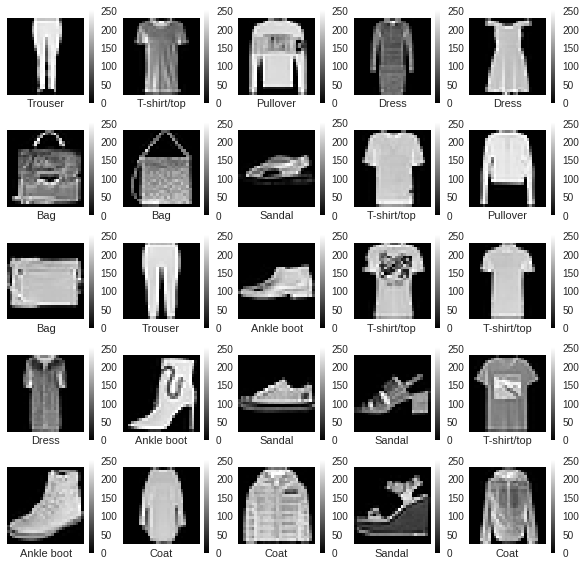

In [30]:
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print("Checking 25 Random predictions")
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  random_index = np.random.randint(0, len(list(x_test)))
  y = x_test[random_index].numpy()
  plt.imshow(y[:,:,0], cmap='gray')
  plt.colorbar()
  numerical_label = text_labels[predicted_classes[random_index]]
  plt.xlabel(numerical_label)

# CIFAR-10 Datatset
A dataset of 50000 32 x 32 colour training images - with 10 categories. Sadly, my implementation of this has never truly recieved a good output - however, [this Notebook](https://colab.research.google.com/drive/1BF9gBZhqoNELlnofxSFymYMMT_T0Okmv) has a great implemenation.

Download the dataset, and set up the labels to classify things

In [31]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

 68329472/170498071 [===========>..................] - ETA: 43s

KeyboardInterrupt: ignored

Creating training and testing sets

In [0]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

Verifying the data types of the lables/images

In [0]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

Create data to be used

In [0]:
x_train = tf.convert_to_tensor(train_images,dtype=tf.float32)
y_train = tf.convert_to_tensor(train_labels, dtype=tf.int64)

x_test  = tf.convert_to_tensor(validation_images, dtype=tf.float32)
y_test  = tf.convert_to_tensor(validation_labels, dtype=tf.int64)

Print out 25 demo images

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

Create a new CNN model that takes in images, as the previous model did

In [0]:
objectModel = tf.keras.Sequential()
objectModel.add(tf.keras.layers.Conv2D(32, (3, 3),input_shape=(32,32,3)))
objectModel.add(tf.keras.layers.Activation('relu'))
objectModel.add(tf.keras.layers.Conv2D(32, (3, 3)))
objectModel.add(tf.keras.layers.Activation('relu'))
objectModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
objectModel.add(tf.keras.layers.Dropout(0.25))

objectModel.add(tf.keras.layers.Conv2D(128, (3, 3)))
objectModel.add(tf.keras.layers.Activation('relu'))
objectModel.add(tf.keras.layers.Conv2D(128, (3, 3)))
objectModel.add(tf.keras.layers.Activation('relu'))
objectModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
objectModel.add(tf.keras.layers.Dropout(0.25))

objectModel.add(tf.keras.layers.Flatten())
objectModel.add(tf.keras.layers.Dense(1024))
objectModel.add(tf.keras.layers.Activation('relu'))
objectModel.add(tf.keras.layers.Dropout(0.5))
objectModel.add(tf.keras.layers.Dense(10))
objectModel.add(tf.keras.layers.Activation('softmax'))
objectModel.summary()

Compile the model


In [0]:
objectModel.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

Make the images tensors

In [0]:
print(x_train.shape)

Run the model with training date

In [0]:
objectModel.fit(x_train, y_train, epochs=20)

Evaluate the model

In [0]:
objectModel.evaluate(x_test, y_test)

Predict with the model


In [0]:
predicted_classes = objectModel.predict_classes(x_test)

Print out a demo

In [0]:
cifar_labels[predicted_classes[3]]

In [0]:
print("Checking 25 Random predictions")
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  random_index = np.random.randint(0, len(list(x_test)))
  y = x_test[random_index].numpy()
  plt.imshow(y)
  numerical_label = cifar_labels[predicted_classes[random_index]]
  plt.xlabel(numerical_label)